In [5]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

df = pd.read_pickle('/content/drive/MyDrive/df_EDA.pkl')
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,title,description,job_skills,job_industries,pay_period,compensation_type,max_salary,med_salary,min_salary,normalized_salary,...,country_grouped,city,fips,name,description_company,address,follower_count,currency,company_size_label,posting_days
0,Marketing Coordinator,Job descriptionA leading real estate firm in N...,Marketing; Sales,Real Estate,HOURLY,BASE_SALARY,20.0,NaN,17.0,38480.0,...,US,Jersey City,34021.0,Corcoran Sawyer Smith,With years of experience helping local buyers ...,242 Tenth Street,2351.0,USD,50–160 employees,30.0
1,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",Health Care Provider,NaN,HOURLY,BASE_SALARY,50.0,NaN,30.0,83200.0,...,NaN,NaN,8069.0,NaN,NaN,NaN,NaN,USD,NaN,30.0
2,Assitant Restaurant Manager,The National Exemplar is accepting application...,Management; Manufacturing,Restaurants,YEARLY,BASE_SALARY,65000.0,NaN,45000.0,55000.0,...,US,Mariemont,39061.0,The National Exemplar,"In April of 1983, The National Exemplar began ...",6880 Wooster Pike,40.0,USD,10–70 employees,30.0
3,Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,Other,Law Practice,YEARLY,BASE_SALARY,175000.0,NaN,140000.0,157500.0,...,US,Lake Success,36059.0,"Abrams Fensterman, LLP","Abrams Fensterman, LLP is a full-service law f...",3 Dakota Drive,2427.0,USD,50–160 employees,30.0
4,Service Technician,Looking for HVAC service tech with experience ...,Information Technology,Facilities Services,YEARLY,BASE_SALARY,80000.0,NaN,60000.0,70000.0,...,NaN,NaN,19057.0,NaN,NaN,NaN,NaN,USD,NaN,30.0


In [19]:
# Step 2: IQR summary + flags (no mutation to df)
import numpy as np

# numeric columns only (keeps year/month as float if present)
num_cols = df.select_dtypes(include="number").columns.tolist()

def iqr_bounds(s):
    # Returns (Q1, Q3, IQR, lower, upper)
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return q1, q3, iqr, lower, upper

# Build summary table
rows = []
for col in num_cols:
    q1, q3, iqr, lower, upper = iqr_bounds(df[col].dropna())
    out_cnt = ((df[col] < lower) | (df[col] > upper)).sum()
    rows.append([col, q1, q3, iqr, lower, upper, out_cnt])

iqr_df = pd.DataFrame(rows, columns=["column","Q1","Q3","IQR","lower_bound","upper_bound","outliers"])

# Binary outlier flags dataframe (1=outlier, 0=not)
df_outlier_flags = pd.DataFrame(index=df.index)
for col in num_cols:
    q1, q3, iqr, lower, upper = iqr_bounds(df[col].dropna())
    df_outlier_flags[col] = ((df[col] < lower) | (df[col] > upper)).astype(int)

iqr_df.head(10), df_outlier_flags.head(3).sum()


(                 column            Q1            Q3           IQR  \
 0            max_salary  4.828000e+01  1.400000e+05  1.399517e+05   
 1            med_salary  1.894000e+01  2.510500e+03  2.491560e+03   
 2            min_salary  3.700000e+01  1.000000e+05  9.996300e+04   
 3     normalized_salary  5.200000e+04  1.250000e+05  7.300000e+04   
 4                 views  3.000000e+00  8.000000e+00  5.000000e+00   
 5               applies  1.000000e+00  8.000000e+00  7.000000e+00   
 6             sponsored  0.000000e+00  0.000000e+00  0.000000e+00   
 7  original_listed_time  1.712863e+12  1.713478e+12  6.154480e+08   
 8           listed_time  1.712886e+12  1.713484e+12  5.980840e+08   
 9           listed_year  2.024000e+03  2.024000e+03  0.000000e+00   
 
     lower_bound   upper_bound  outliers  
 0 -2.098793e+05  3.499276e+05       364  
 1 -3.718400e+03  6.247840e+03      1497  
 2 -1.499075e+05  2.499445e+05       293  
 3 -5.750000e+04  2.345000e+05       952  
 4 -4.500000e

In [21]:
# Step 3: Label copy like the class demo (keeps original df intact)
def label_outliers_iqr(df_in):
    # Returns a copy where numeric outliers are replaced with the string 'Outlier'
    out = df_in.copy()
    for col in df_in.select_dtypes(include="number").columns:
        q1, q3 = out[col].quantile(0.25), out[col].quantile(0.75)
        lower, upper = q1 - 1.5*(q3-q1), q3 + 1.5*(q3-q1)
        out[col] = np.where((out[col] < lower) | (out[col] > upper), 'Outlier', out[col])
    return out

df_labeled = label_outliers_iqr(df)
df_labeled.head(10)


,title,description,job_skills,job_industries,pay_period,compensation_type,max_salary,med_salary,min_salary,normalized_salary,...,country_grouped,city,fips,name,description_company,address,follower_count,currency,company_size_label,posting_days
0,Marketing Coordinator,Job descriptionA leading real estate firm in N...,Marketing; Sales,Real Estate,HOURLY,BASE_SALARY,20.0,nan,17.0,38480.0,...,US,Jersey City,34021.0,Corcoran Sawyer Smith,With years of experience helping local buyers ...,242 Tenth Street,2351.0,USD,50–160 employees,30.0
1,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",Health Care Provider,NaN,HOURLY,BASE_SALARY,50.0,nan,30.0,83200.0,...,NaN,NaN,8069.0,NaN,NaN,NaN,nan,USD,NaN,30.0
2,Assitant Restaurant Manager,The National Exemplar is accepting application...,Management; Manufacturing,Restaurants,YEARLY,BASE_SALARY,65000.0,nan,45000.0,55000.0,...,US,Mariemont,39061.0,The National Exemplar,"In April of 1983, The National Exemplar began ...",6880 Wooster Pike,40.0,USD,10–70 employees,30.0
3,Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,Other,Law Practice,YEARLY,BASE_SALARY,175000.0,nan,140000.0,157500.0,...,US,Lake Success,36059.0,"Abrams Fensterman, LLP","Abrams Fensterman, LLP is a full-service law f...",3 Dakota Drive,2427.0,USD,50–160 employees,30.0
4,Service Technician,Looking for HVAC service tech with experience ...,Information Technology,Facilities Services,YEARLY,BASE_SALARY,80000.0,nan,60000.0,70000.0,...,NaN,NaN,19057.0,NaN,NaN,NaN,nan,USD,NaN,30.0
5,Economic Development and Planning Intern,Job summary:The Economic Development & Plannin...,Project Management,Non-profit Organization Management,HOURLY,BASE_SALARY,20.0,nan,14.0,35360.0,...,US,Raleigh,37183.0,Downtown Raleigh Alliance,Mission of the Downtown Raleigh Alliance (DRA)...,333 Fayetteville St,7825.0,USD,10–70 employees,30.0
6,Producer,Company DescriptionRaw Cereal is a creative de...,Art/Creative; Design; Information Technology,Design Services,YEARLY,BASE_SALARY,300000.0,nan,60000.0,180000.0,...,US,Los Angeles,nan,Raw Cereal,Raw Cereal is a creative design agency focused...,0,447.0,USD,NaN,30.0
7,Building Engineer,Summary: Due to the pending retirement of our ...,Management; Manufacturing,Food and Beverage Services; Hospitality,YEARLY,BASE_SALARY,120000.0,nan,90000.0,105000.0,...,NaN,NaN,6075.0,NaN,NaN,NaN,nan,USD,NaN,Outlier
8,Respiratory Therapist,"At Children’s, the region’s only full-service ...",Health Care Provider,Hospitals and Health Care,NaN,NaN,nan,nan,nan,nan,...,US,Omaha,31055.0,Children's Nebraska,"At Children’s Nebraska, our mission is to impr...",8200 Dodge Street,13313.0,NaN,700–2400 employees,30.0
9,Worship Leader,It is an exciting time to be a part of our chu...,Art/Creative; Design; Information Technology,Religious Institutions,MONTHLY,BASE_SALARY,nan,350.0,nan,4200.0,...,US,Melbourne,12009.0,Bay West Church,Bay West Church began as a campus of First Bap...,3301 Dairy Rd,3.0,USD,NaN,30.0


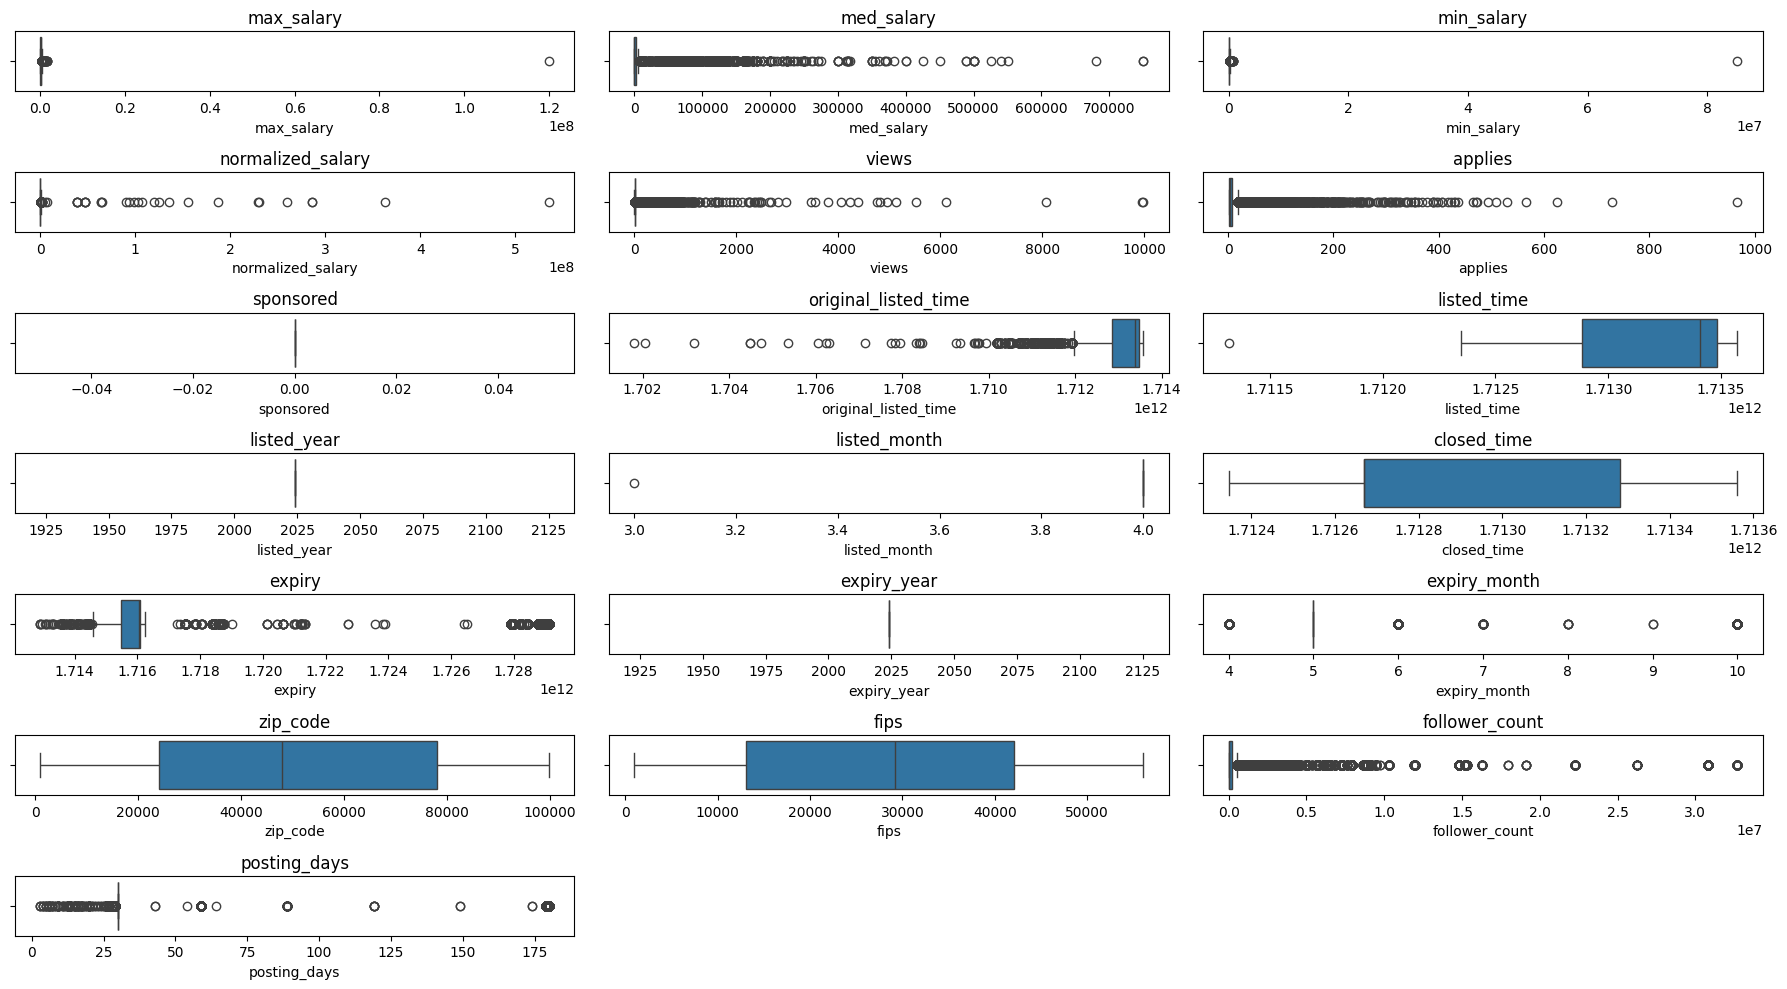

In [22]:
# Optional: compact boxplots for numeric columns (no mutation)
import matplotlib.pyplot as plt
import seaborn as sns

def boxplots_grid(df_in, cols=None, per_row=3, figsize=(18, 10)):
    # Simple grid of boxplots over numeric columns
    cols = cols or df_in.select_dtypes(include="number").columns.tolist()
    if not cols:
        return
    rows = int(np.ceil(len(cols)/per_row))
    fig, axes = plt.subplots(rows, per_row, figsize=figsize)
    axes = np.atleast_2d(axes)
    for i, col in enumerate(cols):
        r, c = divmod(i, per_row)
        sns.boxplot(x=df_in[col], ax=axes[r, c])
        axes[r, c].set_title(col)
    # hide empty axes
    for j in range(len(cols), rows*per_row):
        r, c = divmod(j, per_row); axes[r, c].set_visible(False)
    plt.tight_layout(); plt.show()

boxplots_grid(df)


In [23]:
# Step 1: Create a version without outliers (for correlation only)
import numpy as np
import pandas as pd

def remove_outliers_for_corr(df):
    """Return df without rows containing any IQR outliers."""
    clean = df.copy()
    num_cols = clean.select_dtypes(include="number").columns

    for col in num_cols:
        x = clean[col]
        q1, q3 = x.quantile(0.25), x.quantile(0.75)
        iqr = q3 - q1
        lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
        clean = clean[(x >= lower) & (x <= upper)]

    return clean

df_no_out = remove_outliers_for_corr(df)
df_no_out.shape


(0, 47)

In [24]:
# Step 2: Correlation on original df
corr_original = df.select_dtypes(include="number").corr()
corr_original


,max_salary,med_salary,min_salary,normalized_salary,views,applies,sponsored,original_listed_time,listed_time,listed_year,listed_month,closed_time,expiry,expiry_year,expiry_month,zip_code,fips,follower_count,posting_days
max_salary,1.000000,NaN,0.998226,0.107118,0.002937,-0.005922,NaN,-0.004550,0.000871,NaN,NaN,0.069739,0.023558,NaN,0.023621,-0.004322,0.001960,0.022245,0.023636
med_salary,NaN,1.000000,NaN,0.669374,0.037125,-0.023131,NaN,0.004481,0.001802,NaN,0.005312,0.130466,0.045704,NaN,0.046511,-0.044134,-0.003487,-0.023869,0.046210
min_salary,0.998226,NaN,1.000000,0.107884,0.003579,-0.005633,NaN,-0.002233,0.001428,NaN,NaN,0.052009,0.024406,NaN,0.024417,-0.005512,0.001383,0.014631,0.024388
normalized_salary,0.107118,0.669374,0.107884,1.000000,-0.001513,-0.002239,NaN,-0.000132,-0.001448,NaN,0.000167,0.096179,0.003046,NaN,0.003269,0.011771,0.002747,-0.000819,0.003285
views,0.002937,0.037125,0.003579,-0.001513,1.000000,0.494305,NaN,-0.024381,-0.010586,NaN,0.000387,0.271234,0.050233,NaN,0.052728,-0.000920,-0.005265,0.013759,0.052669
applies,-0.005922,-0.023131,-0.005633,-0.002239,0.494305,1.000000,NaN,0.018458,0.016662,NaN,NaN,NaN,0.047732,NaN,0.045979,-0.002178,0.003476,-0.008583,0.045844
sponsored,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
original_listed_time,-0.004550,0.004481,-0.002233,-0.000132,-0.024381,0.018458,NaN,1.000000,0.820159,NaN,0.010757,0.880331,0.139982,NaN,0.000104,-0.009944,-0.005577,-0.094507,-0.000560
listed_time,0.000871,0.001802,0.001428,-0.001448,-0.010586,0.016662,NaN,0.820159,1.000000,NaN,0.013445,0.999951,0.164776,NaN,-0.005875,-0.003383,-0.008529,0.012710,-0.006043
listed_year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Step 3: Correlation without outliers
corr_no_out = df_no_out.select_dtypes(include="number").corr()
corr_no_out


,max_salary,med_salary,min_salary,normalized_salary,views,applies,sponsored,original_listed_time,listed_time,listed_year,listed_month,closed_time,expiry,expiry_year,expiry_month,zip_code,fips,follower_count,posting_days
max_salary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
med_salary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min_salary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
normalized_salary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
views,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
applies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sponsored,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
original_listed_time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
listed_time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
listed_year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Step 4: Absolute difference between the two correlation matrices
corr_diff = (corr_original - corr_no_out).abs()
corr_diff


,max_salary,med_salary,min_salary,normalized_salary,views,applies,sponsored,original_listed_time,listed_time,listed_year,listed_month,closed_time,expiry,expiry_year,expiry_month,zip_code,fips,follower_count,posting_days
max_salary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
med_salary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min_salary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
normalized_salary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
views,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
applies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sponsored,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
original_listed_time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
listed_time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
listed_year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# Step 5: Columns where outliers significantly changed correlations
THRESHOLD = 0.10

problematic_cols = corr_diff.max().sort_values(ascending=False)
problematic_cols = problematic_cols[problematic_cols >= THRESHOLD]

problematic_cols


,0


In [28]:
import numpy as np

def iqr_to_nan(df):
    """Replace outliers with NaN using the 1.5*IQR rule."""
    clean = df.copy()
    num_cols = clean.select_dtypes(include="number").columns

    for col in num_cols:
        x = clean[col]

        Q1 = x.quantile(0.25)
        Q3 = x.quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        clean[col] = np.where((x < lower) | (x > upper), np.nan, clean[col])

    return clean

# Run
df_clean = iqr_to_nan(df)
df_clean.head()


,title,description,job_skills,job_industries,pay_period,compensation_type,max_salary,med_salary,min_salary,normalized_salary,...,country_grouped,city,fips,name,description_company,address,follower_count,currency,company_size_label,posting_days
0,Marketing Coordinator,Job descriptionA leading real estate firm in N...,Marketing; Sales,Real Estate,HOURLY,BASE_SALARY,20.0,NaN,17.0,38480.0,...,US,Jersey City,34021.0,Corcoran Sawyer Smith,With years of experience helping local buyers ...,242 Tenth Street,2351.0,USD,50–160 employees,30.0
1,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",Health Care Provider,NaN,HOURLY,BASE_SALARY,50.0,NaN,30.0,83200.0,...,NaN,NaN,8069.0,NaN,NaN,NaN,NaN,USD,NaN,30.0
2,Assitant Restaurant Manager,The National Exemplar is accepting application...,Management; Manufacturing,Restaurants,YEARLY,BASE_SALARY,65000.0,NaN,45000.0,55000.0,...,US,Mariemont,39061.0,The National Exemplar,"In April of 1983, The National Exemplar began ...",6880 Wooster Pike,40.0,USD,10–70 employees,30.0
3,Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,Other,Law Practice,YEARLY,BASE_SALARY,175000.0,NaN,140000.0,157500.0,...,US,Lake Success,36059.0,"Abrams Fensterman, LLP","Abrams Fensterman, LLP is a full-service law f...",3 Dakota Drive,2427.0,USD,50–160 employees,30.0
4,Service Technician,Looking for HVAC service tech with experience ...,Information Technology,Facilities Services,YEARLY,BASE_SALARY,80000.0,NaN,60000.0,70000.0,...,NaN,NaN,19057.0,NaN,NaN,NaN,NaN,USD,NaN,30.0


In [29]:
# Save pickle in the current notebook session
# df_clean.to_pickle("df_clean.pkl")


In [30]:
# Save pickle to Google Drive (update folder if needed)
# df_clean.to_pickle("/content/drive/MyDrive/df_clean.pkl")


In [31]:
# from google.colab import files
# files.download("df_clean.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>